# USRP Timestream Stability
Notebook to look at jitter in a single USRP timestream and between timestreams.
## Import the libraries

In [1]:
import sys # , os, glob, h5py
# import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load the modules
sys.path.insert(1, "/home/nexus-admin/NEXUS_RF/BackendTools")
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

In [2]:
# %matplotlib notebook

## Get the data files and metadata

In [3]:
datapath = '/data/USRP_Laser_Data'
series   = "20221206_182655" # "20221206_105445" # 

In [4]:
sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0.h5
/data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_2.h5
/data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_5.h5
/data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_8.h5


In [5]:
md, charFs, charZs = Thf.UnpackSummary(sum_file)
rf_power = md['power']
print("RF Power at USRP:", rf_power, "dBm")

## Since I fucked up the acquisition script this business has to be done to fix the arrays
if np.all(charZs[0].real==0):
    charZs[0] = charFs[0]
    charFs[0] = charFs[-1]

## Readout frequencies are real
charFs = charFs.real

RF Power at USRP: -30 dBm


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


In [6]:
## Extract the noise acquisition settings, assuming they're all the same
for k in md.keys():
    if 'Scan1' in k:
        lapse_sec   = md[k]['duration'][0]
        break
    continue
print("Duration:",lapse_sec,"sec")

Duration: 30.0 sec


In [7]:
# PUf.vna_file_fit(vna_file,[4.24204],show=False,save=False)

## Method 1: Use the cleaned and mean-subtracted timestreams

In [8]:
## Analysis Parameters
f_trans        = 0.00
len_chunks_sec = 3.00

In [9]:
## Focus index
iix = 3

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_cleaned.h5 because override=True!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_2.h5 because override=True!
found 7 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_2_cleaned.h5 because override=True!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_5.h

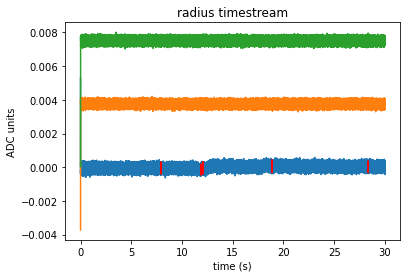

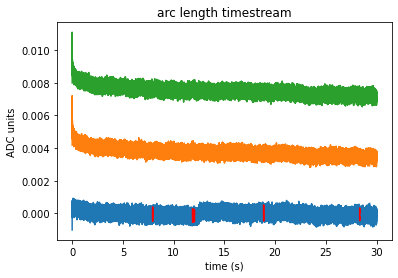

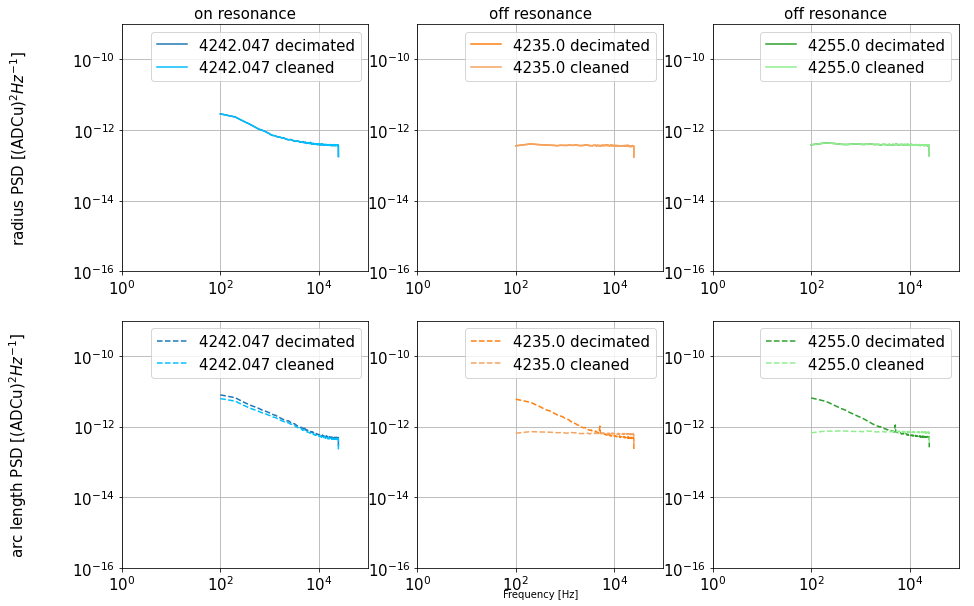

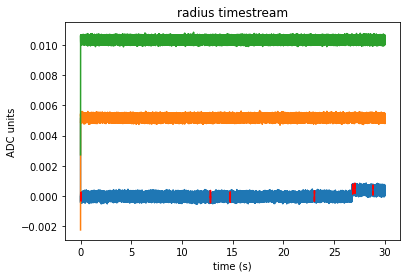

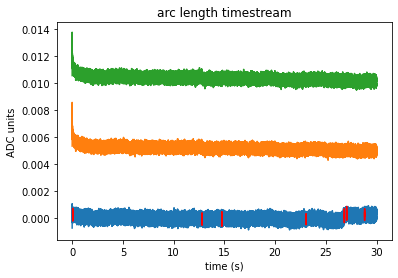

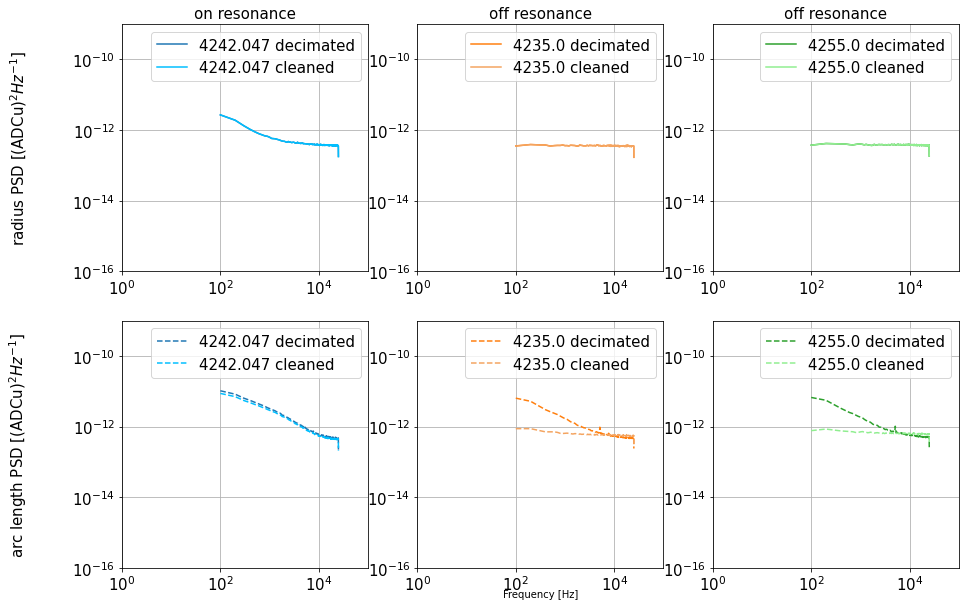

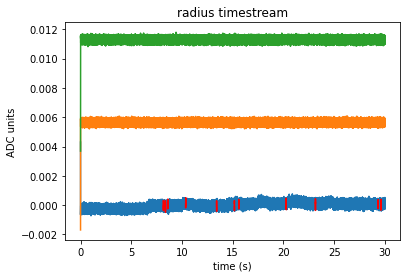

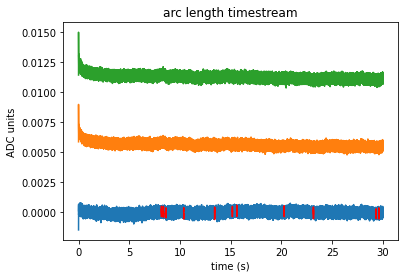

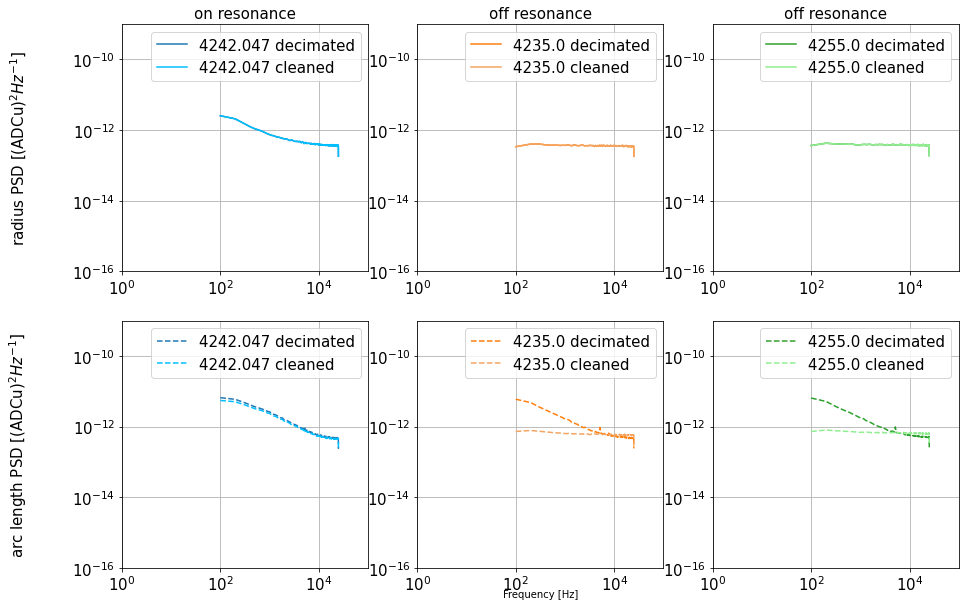

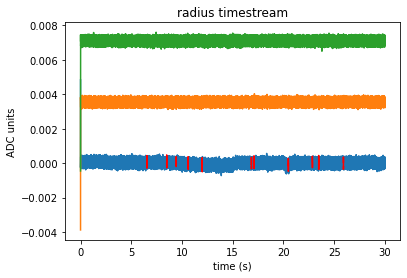

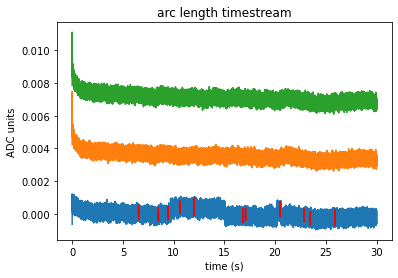

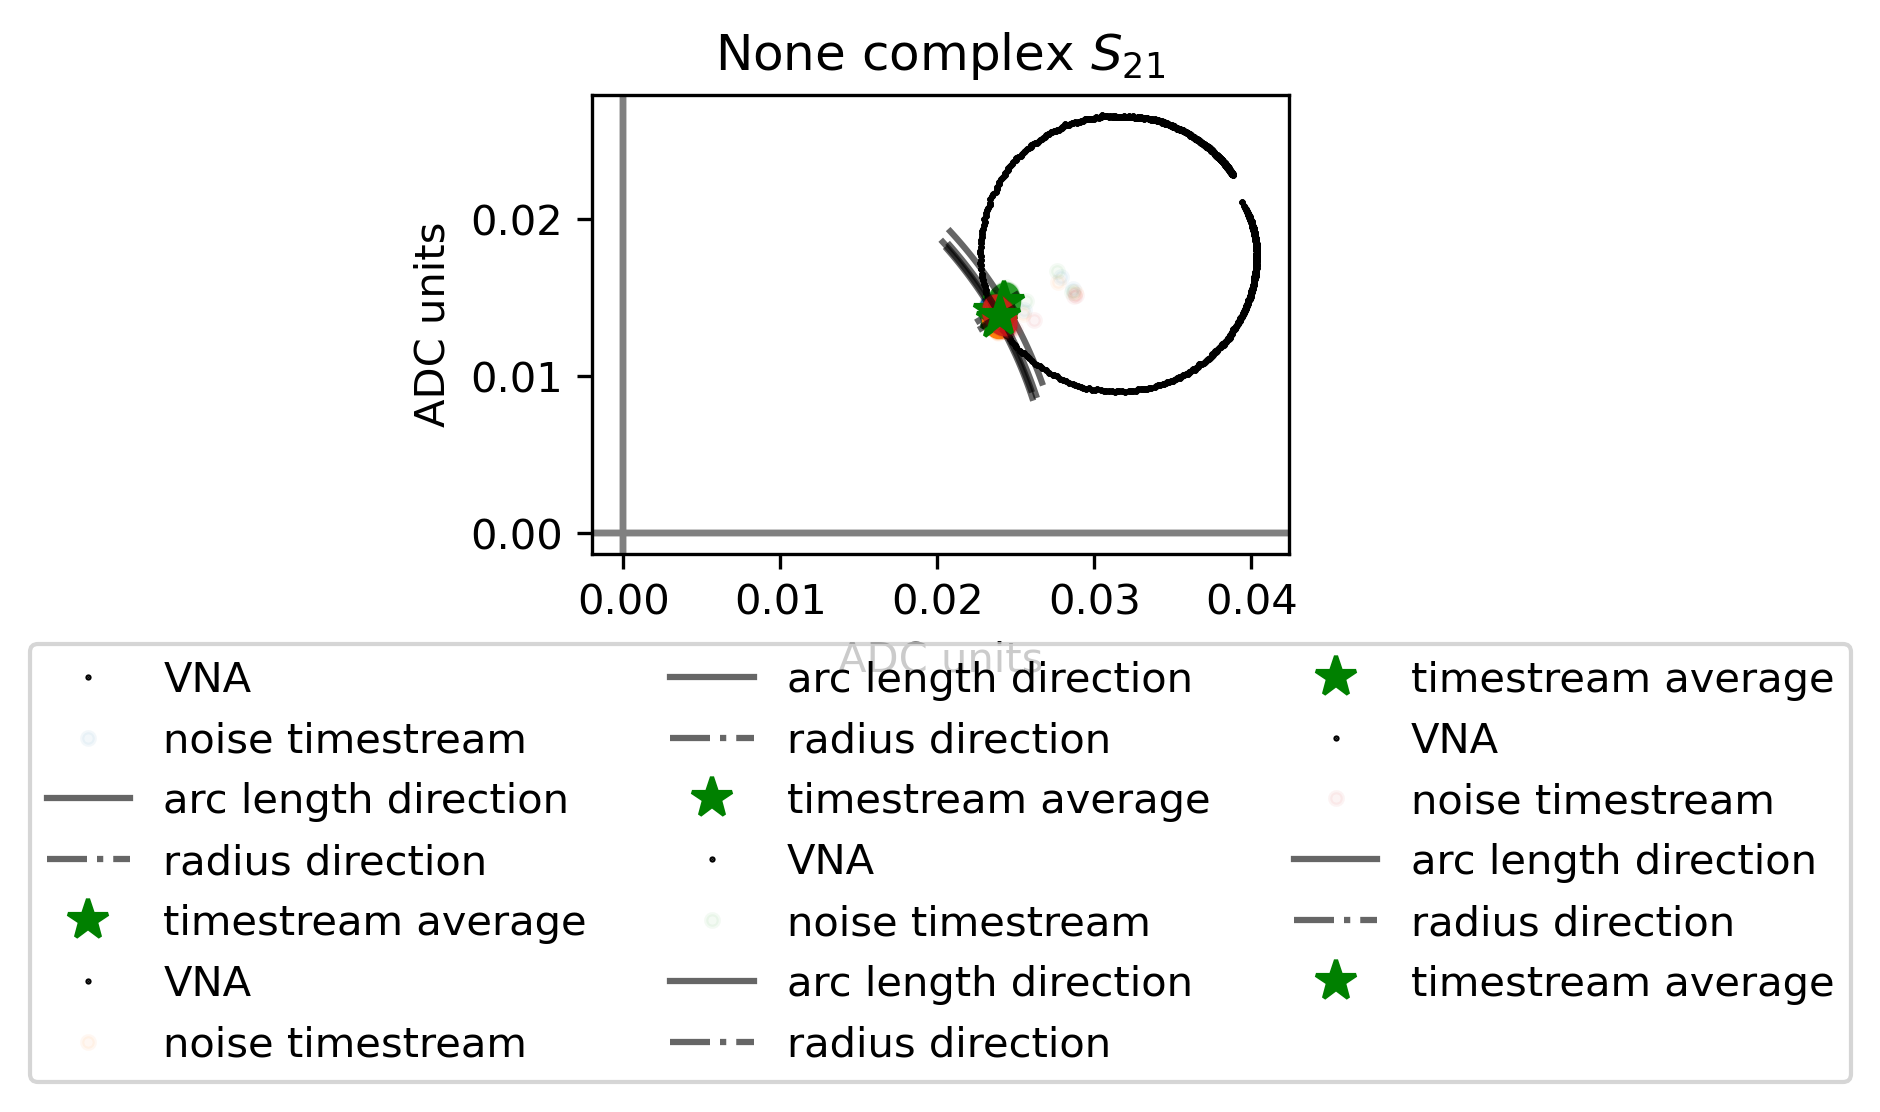

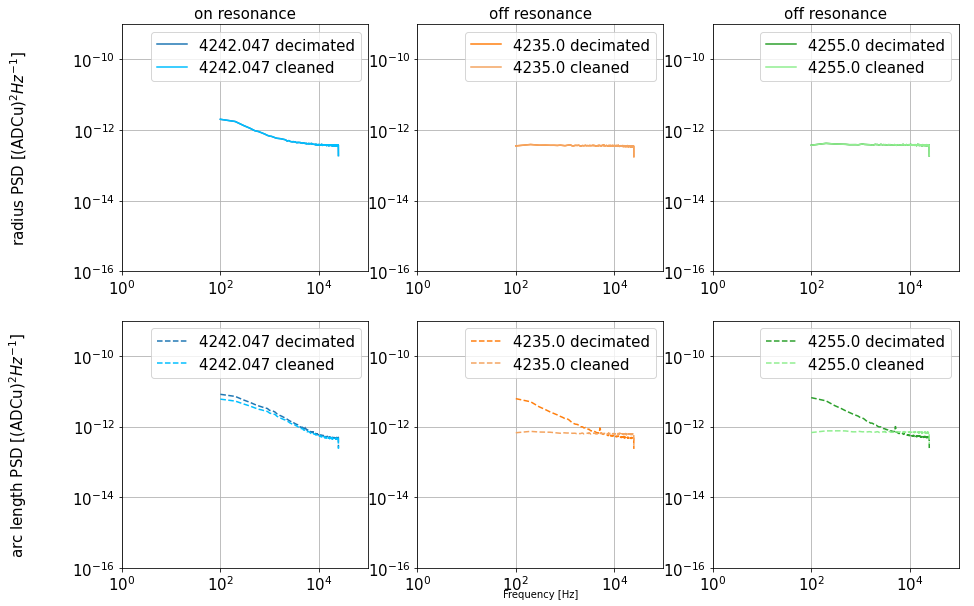

In [10]:
ts_data = {}

for i in np.arange(len(nse_files)):
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[i], vna_file, f_transient=f_trans,
#                                                    charFs = charFs[i],
#                                                    charZs = charZs[i],
#                                                    MBresults = MB_fit_vals,
                                                   show_plots= True, 
                                                   verbose   = False)
    ts_data[nse_files[i]] = timestreams
    
for k,v in ts_data.items():
    print(k, ":", v.keys())

Text(0.5, 1.0, 'Electronics basis (error bars are std. dev.)')

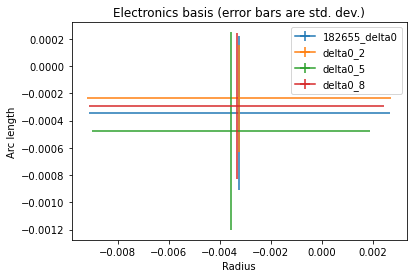

In [11]:
ax1 = plt.figure('no-chunks-elec').gca()
ax1.set_xlabel(r"Radius")
ax1.set_ylabel(r"Arc length")

# ax2 = plt.figure('no-chunks-res').gca()
# ax2.set_xlabel(r"Dissipation")
# ax2.set_ylabel(r"Frequency")

# ax3 = plt.figure('no-chunks-qp').gca()
# ax3.set_xlabel(r"$\kappa_1$")
# ax3.set_ylabel(r"$\kappa_2$")

for i in np.arange(len(nse_files)):
    mean_rad = np.mean( ts_data[nse_files[i]]['radius'][0] )
    sdev_rad = np.std(  ts_data[nse_files[i]]['radius'][0] )
    mean_arc = np.mean( ts_data[nse_files[i]]['arc'][0] )
    sdev_arc = np.std(  ts_data[nse_files[i]]['arc'][0] )
    
    ax1.errorbar( [mean_rad], [mean_arc], xerr=sdev_rad, yerr=sdev_arc, 
                 label="_".join(nse_files[i].split(".")[0].split("_")[-2:]) )
    
#     mean_dis = np.mean( ts_data[nse_files[i]]['dissipation'] )
#     sdev_dis = np.std(  ts_data[nse_files[i]]['dissipation'] )
#     mean_frq = np.mean( ts_data[nse_files[i]]['frequency'] )
#     sdev_frq = np.std(  ts_data[nse_files[i]]['frequency'] )
    
#     ax2.errorbar( [mean_dis], [mean_frq], xerr=sdev_dis, yerr=sdev_frq, 
#                  label="_".join(nse_files[i].split(".")[0].split("_")[-2:]) )
    
#     mean_k1 = np.mean( ts_data[nse_files[i]]['k1'] )
#     sdev_k1 = np.std(  ts_data[nse_files[i]]['k1'] )
#     mean_k2 = np.mean( ts_data[nse_files[i]]['k2'] )
#     sdev_k2 = np.std(  ts_data[nse_files[i]]['k2'] )
    
#     ax3.errorbar( [mean_k1], [mean_k2], xerr=sdev_k1, yerr=sdev_k2, 
#                  label="_".join(nse_files[i].split(".")[0].split("_")[-2:]) )
    
ax1.legend()
ax1.set_title("Electronics basis (error bars are std. dev.)")

# ax2.legend()
# ax2.set_title("Resonator basis (error bars are std. dev.)")

# ax3.legend()
# ax3.set_title("Quasiparticle basis (error bars are std. dev.)")

In [12]:
## Define the chunks
len_data_sec   = (1.0 - f_trans)*lapse_sec
N_chunks       = int(np.ceil(len_data_sec/len_chunks_sec))
print("Breaking",len_data_sec,"seconds of data into",N_chunks,"chunks of",len_chunks_sec,"seconds each.")

## Create the "bin" edges
t0 = f_trans*lapse_sec
t1 = lapse_sec
dt = len_chunks_sec
edges = np.arange(start=t0, stop=t1+dt, step=dt)
print("Edge start times (s):",edges[:-1])
print("Final chunk is only",t1-edges[-2],"seconds long")

Breaking 30.0 seconds of data into 10 chunks of 3.0 seconds each.
Edge start times (s): [ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]
Final chunk is only 3.0 seconds long


In [13]:
## Chunk an array of values v with times t into chunks with given start times tb
def chunk_data(tb,t,v):
    out_time = {}
    out_vals = {}
    
    n_bins = len(tb)
    tb = np.append(tb,t[-1])
    
    for i in np.arange(n_bins):
        ot = t[(t>tb[i]) * (t<=tb[i+1])]
        ov = v[(t>tb[i]) * (t<=tb[i+1])]
        out_time[tb[i]] = ot
        out_vals[tb[i]] = ov
        
    return out_time, out_vals

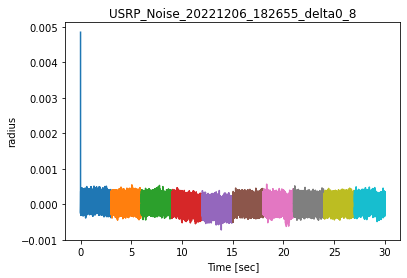

In [14]:
direct = 'radius' # 'arc' # 
d_times, d_vals = chunk_data(edges[:-1], ts_data[nse_files[iix]]['time'], ts_data[nse_files[iix]][direct][:,0])


ax1 = plt.figure('chunks').gca()
ax1.set_xlabel("Time [sec]")
ax1.set_ylabel(direct)
ax1.set_title(nse_files[iix].split(".")[0].split("/")[-1])

for tb in edges[:-1]:
    ax1.plot(d_times[tb],d_vals[tb])

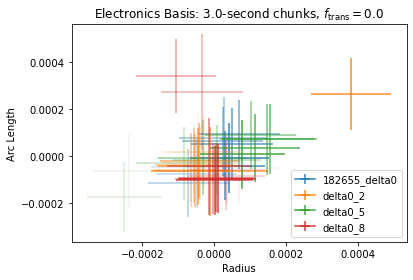

In [15]:
## Create a plot
ax1 = plt.figure('all-chunked').gca()

ax1.set_xlabel("Radius")
ax1.set_ylabel("Arc Length")
ax1.set_title("Electronics Basis: "+str(int(len_chunks_sec*10)/10.)+"-second chunks, "+r"$f_\mathrm{trans}=$"+str(int(100.0*f_trans)/100.))

alpha_step = 1.0/len(edges)

## For every noise file
for ii in np.arange(len(nse_files)):
    lbl_str = "_".join(nse_files[ii].split(".")[0].split("_")[-2:])
    col_str = "C"+str(int(ii))
    
    _, r_vals = chunk_data(edges[:-1], ts_data[nse_files[ii]]['time'], ts_data[nse_files[ii]]['radius'][:,0])
    _, a_vals = chunk_data(edges[:-1], ts_data[nse_files[ii]]['time'], ts_data[nse_files[ii]]['arc'][:,0])
    
    alpha = alpha_step
    for tb in edges[:-1]:
        m_rad = np.mean(r_vals[tb])
        s_rad = np.std( r_vals[tb])
        m_arc = np.mean(a_vals[tb])
        s_arc = np.std( a_vals[tb])
        
        ax1.errorbar(m_rad,m_arc,xerr=s_rad,yerr=s_arc,c=col_str,alpha=alpha,
                      label=lbl_str if alpha>alpha_step*(len(edges)-1.5) else None)
        
        alpha += alpha_step
        
ax1.legend()

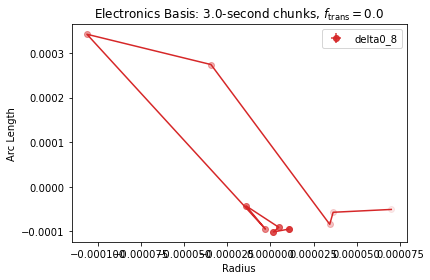

In [16]:
## Create a plot
show_err = False
ax1 = plt.figure('single-chunked').gca()

ax1.set_xlabel("Radius")
ax1.set_ylabel("Arc Length")
ax1.set_title("Electronics Basis: "+str(int(len_chunks_sec*10)/10.)+"-second chunks, "+r"$f_\mathrm{trans}=$"+str(int(100.0*f_trans)/100.))

alpha_step = 1.0/len(edges)

## For a single noise file
lbl_str = "_".join(nse_files[iix].split(".")[0].split("_")[-2:])
col_str = "C"+str(int(iix))

_, r_vals = chunk_data(edges[:-1], ts_data[nse_files[iix]]['time'], ts_data[nse_files[iix]]['radius'][:,0])
_, a_vals = chunk_data(edges[:-1], ts_data[nse_files[iix]]['time'], ts_data[nse_files[iix]]['arc'][:,0])

alpha = alpha_step

mx = np.array([])
my = np.array([])

for tb in edges[:-1]:
    m_rad = np.mean(r_vals[tb]) ; mx = np.append(mx,m_rad)
    s_rad = np.std( r_vals[tb])
    m_arc = np.mean(a_vals[tb]) ; my = np.append(my,m_arc)
    s_arc = np.std( a_vals[tb])

    ax1.errorbar(m_rad,m_arc,xerr=show_err*s_rad,yerr=show_err*s_arc,c=col_str,alpha=alpha,
                 marker="None" if show_err else "o",
                 ls    ="None" if show_err else "",
                 label=lbl_str if alpha>alpha_step*(len(edges)-1.5) else None)

    alpha += alpha_step
    
if not show_err:
    ax1.plot(mx,my,color=col_str,ls='-',marker="None")
        
ax1.legend()

In [17]:
'''def PlotDrift(series,datapath,len_chunks_sec,f_trans,verbose=True):
    ## Get all the files for this series
    sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=verbose)
    
    ## Unpack the summary file to get some metadata of interest
    md, _, _ = Thf.UnpackSummary(sum_file)
    rf_power = md['power']
    if verbose:
        print("RF Power at USRP:", rf_power, "dBm")
        
    ## Create a dictionary in which to store clean data
    ts_data = {}
    
    ## Create a plot
    ax1 = plt.figure('all-chunked').gca()

    ax1.set_xlabel("Radius")
    ax1.set_ylabel("Arc Length")
    ax1.set_title("Electronics Basis: "+str(int(len_chunks_sec*10)/10.)+"-second chunks")

    

    ## Loop over each noise file
    for ii in np.arange(len(nse_files)):
        ## Some plotting details
        lbl_str = "_".join(nse_files[ii].split(".")[0].split("_")[-2:])
        col_str = "C"+str(int(ii))

        ## Extract the noise acquisition settings
        scan_id = nse_files[ii].split(".")[0].split("/")[-1].split("delta0")[1]
        for k in md.keys():
            if 'Scan'+scan_id in k and not 'LaserScan' in k:
                lapse_sec   = md[k]['duration'][0]
                break
            continue
        if verbose:
            print("Duration:",lapse_sec,"sec")
        
        ## Clean the timestreams, save to dictionary
        powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[ii], vna_file, f_transient=f_trans,
                                                       show_plots= False, 
                                                       verbose   = False)
        ts_data[nse_files[i]] = timestreams
        
        ## Define the chunks
        len_data_sec   = (1.0 - f_trans)*lapse_sec
        N_chunks       = int(np.ceil(len_data_sec/len_chunks_sec))
        if verbose:
            print("Breaking",len_data_sec,"seconds of data into",N_chunks,"chunks of",len_chunks_sec,"seconds each.")

        ## Create the "bin" edges
        t0 = f_trans*lapse_sec
        t1 = lapse_sec
        dt = len_chunks_sec
        edges = np.arange(start=t0, stop=t1+dt, step=dt)
        if verbose:
            print("Edge start times (s):",edges[:-1])
            print("Final chunk is only",t1-edges[-2],"seconds long")
            
        alpha_step = 1.0/len(edges)
        
        _, r_vals = chunk_data(edges[:-1], ts_data[nse_files[ii]]['time'], ts_data[nse_files[ii]]['radius'][:,0])
        _, a_vals = chunk_data(edges[:-1], ts_data[nse_files[ii]]['time'], ts_data[nse_files[ii]]['arc'][:,0])

        alpha = alpha_step
        for tb in edges[:-1]:
            m_rad = np.mean(r_vals[tb])
            s_rad = np.std( r_vals[tb])
            m_arc = np.mean(a_vals[tb])
            s_arc = np.std( a_vals[tb])

            ax1.errorbar(m_rad,m_arc,xerr=s_rad,yerr=s_arc,c=col_str,alpha=alpha,
                          label=lbl_str if alpha>alpha_step*(len(edges)-1.5) else None)

            alpha += alpha_step
        
    ax1.legend()'''

'def PlotDrift(series,datapath,len_chunks_sec,f_trans,verbose=True):\n    ## Get all the files for this series\n    sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, \n                                                        base_path=datapath,\n                                                        sep_noise_laser=True,\n                                                        verbose=verbose)\n    \n    ## Unpack the summary file to get some metadata of interest\n    md, _, _ = Thf.UnpackSummary(sum_file)\n    rf_power = md[\'power\']\n    if verbose:\n        print("RF Power at USRP:", rf_power, "dBm")\n        \n    ## Create a dictionary in which to store clean data\n    ts_data = {}\n    \n    ## Create a plot\n    ax1 = plt.figure(\'all-chunked\').gca()\n\n    ax1.set_xlabel("Radius")\n    ax1.set_ylabel("Arc Length")\n    ax1.set_title("Electronics Basis: "+str(int(len_chunks_sec*10)/10.)+"-second chunks")\n\n    \n\n    ## Loop over each noise file\n    

In [18]:
# PlotDrift(series,datapath,2.5,0.25,verbose=True)

## Method 2: Use raw timestreams after removing bad chunks

In [19]:
def get_time_and_vna(f_vna, f_nse, make_plot=False):
    VNA_f, VNA_z = PUf.read_vna(f_vna)
    data_noise, data_info = PUf.unavg_noi(f_nse)

    data_freqs = data_info['search freqs']
    num_freqs  = len(data_freqs)

    time = data_info['time']
    time_correction = data_info['sampling period']
    fs = int(1./time_correction)

    pulse_times = Prf.storeEvents(f_nse,trig_th=4.5,trig_channel='radius')
    print('found ' + str(len(pulse_times)) + ' pulses')

    ## Break data up from a 2D array into an array of 2D arrays, each of a fixed size
    num_chunks = 100
    chunk_len  = int(len(data_noise) / num_chunks)
    all_chunks = range(num_chunks)
    chunked_timestreams = Prf.create_chunks(data_noise,num_chunks)
    chunked_time        = Prf.create_chunks(time,num_chunks)

    ## Check for any chunks that contain a pulse
    blank_chunks = 40
    bad_chunks = Prf.identify_bad_chunks(chunked_time,pulse_times)
    bad_chunks += range(blank_chunks)

    ## Remove the set of bad chunks from the set of all chunks to get good chunks
    good_chunks = list(set(all_chunks)-set(bad_chunks))
    num_good_chunks = len(good_chunks)
    num_bad_chunks = len(bad_chunks)

    ## Separate only the good chunks out of the chunked timestream
    timestreams_good_chunks = chunked_timestreams[:,good_chunks,:]
    time_good_chunks = chunked_time[:,good_chunks,:]

    ## Reshape the timestreams to be flat 2D, with chunks containing pulses removed
    timestreams_no_pulse = np.reshape(timestreams_good_chunks,(num_good_chunks*chunk_len,num_freqs),order='F')
    time_no_pulse = np.reshape(time_good_chunks,num_good_chunks*chunk_len,order='F')
    
    if make_plot:
        plt.figure()
        plt.scatter(timestreams_no_pulse[:,0].real, timestreams_no_pulse[:,0].imag)
        plt.plot(VNA_z.real,VNA_z.imag,'k-',marker='o')
    
    return time_no_pulse, timestreams_no_pulse[:,0], VNA_z

In [20]:
# time, ts, vna_z = get_time_and_vna(vna_file, nse_files[0], make_plot=False)

In [21]:
%matplotlib notebook

In [22]:
# vfig = PUf.plot_noise_and_vna(ts,vna_z,fit_z=None,char_zs=charZs,alpha=0.05,show_legend=False)

<IPython.core.display.Javascript object>


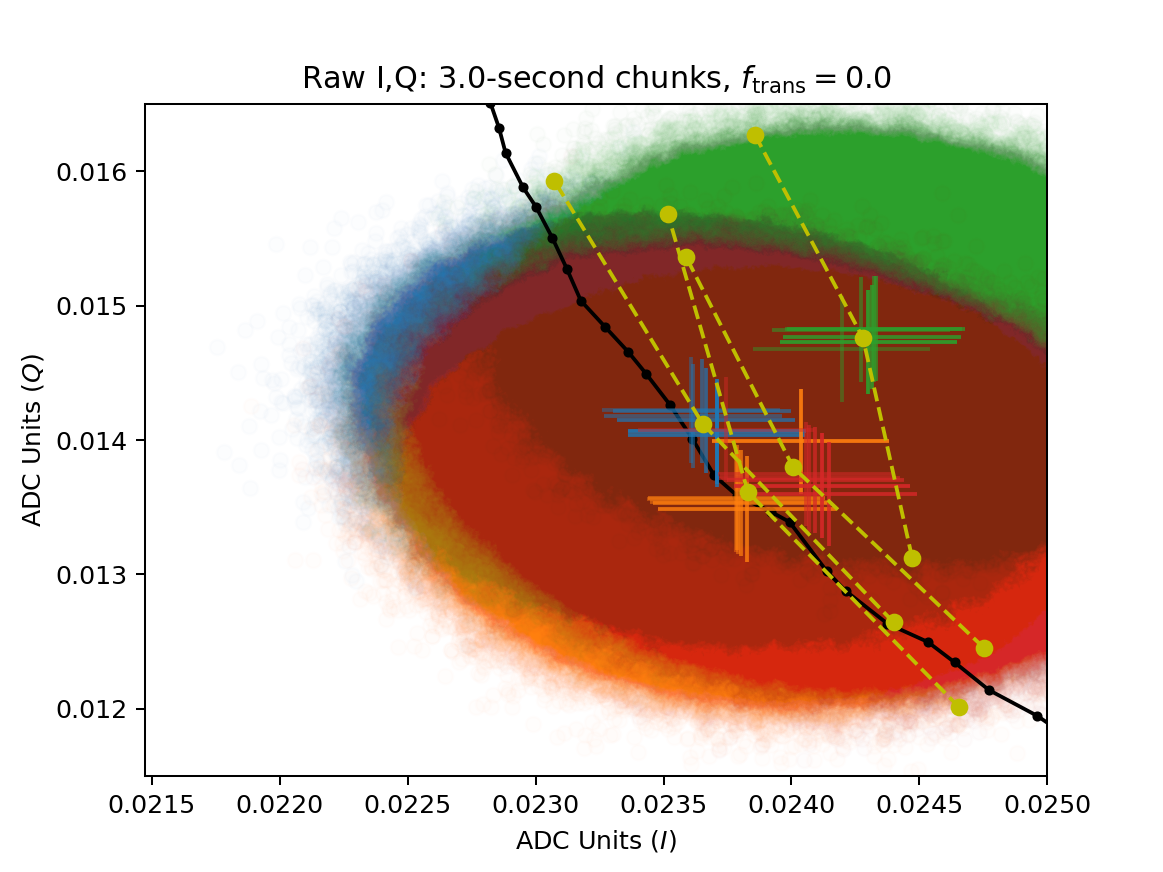

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0.h5 because override=True!
found 5 pulses


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: conver

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_2.h5 because override=True!
found 7 pulses


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: conver

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_5.h5 because override=True!
found 11 pulses


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: conver

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221206/20221206_182655/USRP_Noise_20221206_182655_delta0_8.h5 because override=True!
found 11 pulses


/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/share/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: conver

(0.0115, 0.0165)

In [23]:
## Create a plot
ax1 = plt.figure('all-chunked-2').gca()
# ax1 = vfig.gca()

ax1.set_xlabel(r"ADC Units ($I$)")
ax1.set_ylabel(r"ADC Units ($Q$)")
ax1.set_title("Raw I,Q: "+str(int(len_chunks_sec*10)/10.)+"-second chunks, "+r"$f_\mathrm{trans}=$"+str(int(100.0*f_trans)/100.))

alpha_step = 1.0/len(edges)

for ii in np.arange(len(nse_files)):
    time, ts, vna_z = get_time_and_vna(vna_file, nse_files[ii], make_plot=False)
    if ii==0:
        ax1.plot(vna_z.real,  vna_z.imag,  'k-',marker='.',zorder=2)
    ax1.plot(charZs[ii].real, charZs[ii].imag, 'y--',marker='o',zorder=1000)
    
    lbl_str = "_".join(nse_files[ii].split(".")[0].split("_")[-2:])
    col_str = "C"+str(int(ii))
    
    ax1.scatter(ts.real,ts.imag,color=col_str,alpha=1e-2,zorder=1)
    
    _, r_vals = chunk_data(edges[:-1], time, ts.real)
    _, i_vals = chunk_data(edges[:-1], time, ts.imag)
    
    alpha = alpha_step
    for tb in edges[:-1]:
        m_real = np.mean(r_vals[tb])
        s_real = np.std( r_vals[tb])
        m_imag = np.mean(i_vals[tb])
        s_imag = np.std( i_vals[tb])
        
        ax1.errorbar(m_real,m_imag,xerr=s_real,yerr=s_imag,c=col_str,alpha=alpha,
                      label=lbl_str if alpha>alpha_step*(len(edges)-1.5) else None,
                     zorder=100+ii+alpha)
        
        alpha += alpha_step
        
# ax1.legend()
# ax1.set_aspect('equal')

ax1.set_xlim([0.021475,0.025000])
ax1.set_ylim([0.0115,0.0165])